<a href="https://colab.research.google.com/github/YousefEldeeb787/Bioinformatics-project/blob/main/Bioinformatics_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install biopython


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 18.1 MB/s eta 0:00:00


In [ ]:
import os
folder = "/content/drive/MyDrive/Bioinformatics_Project"

In [ ]:
from Bio import SeqIO

genome_file = "/content/drive/MyDrive/Bioinformatics_Project/test_sample.fna"
contigs = list(SeqIO.parse(genome_file, "fasta"))

print(f"Number of contigs: {len(contigs)}")
print(f"First contig ID: {contigs[0].id}")
print(f"First contig length: {len(contigs[0].seq)}")


Number of contigs: 6315
First contig ID: test_contig_1
First contig length: 662


In [ ]:
from Bio.Seq import Seq
# Define Padding and ORF Finder Functions
# Function to pad sequences to multiple of 3
def pad_sequence(seq):
    remainder = len(seq) % 3
    if remainder != 0:
        seq += 'N' * (3 - remainder)
    return seq

# ORF finder
def find_orfs(seq, min_len=100):
    orfs = []
    for strand, nuc in [(+1, seq), (-1, seq.reverse_complement())]:
        for frame in range(3):
            trans = nuc[frame:].translate(to_stop=False)
            aa_seq = str(trans)
            start = 0
            while True:
                idx = aa_seq.find('M', start)
                if idx == -1:
                    break
                stop_idx = aa_seq.find('*', idx)
                if stop_idx == -1:
                    break
                if stop_idx - idx >= min_len:
                    orfs.append(aa_seq[idx:stop_idx])
                start = idx + 1
    return orfs


In [ ]:
all_orfs = []
for contig in contigs:
    padded_seq = pad_sequence(contig.seq)
    orfs = find_orfs(padded_seq)
    all_orfs.extend(orfs)

print(f"Total ORFs predicted: {len(all_orfs)}")
print(f"Example ORF (first one): {all_orfs[0]}")


/usr/local/lib/python3.12/dist-packages/Bio/Seq.py:2877: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


Total ORFs predicted: 34074
Example ORF (first one): MNTTEYFKRTIQAYLEERAMEDELFAAKYDNPDKNIDDCVTYILNWVQKSGCNGFCDDEIYGQAIHYYEEKDIEVGKPLNCQVSVNHHIELTEEEKAQARQEAIRQYQQEQMNKMRNRDTAKRTSQRTETEVHQPSLFDTL


In [ ]:
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import SeqIO

orf_records = [SeqRecord(Seq(orf), id=f"ORF_{i+1}", description="") for i, orf in enumerate(all_orfs)]
output_fasta = "/content/drive/MyDrive/Bioinformatics_Project/predicted_orfs.faa"
SeqIO.write(orf_records, output_fasta, "fasta")

print(f"ORFs saved to {output_fasta}")


ORFs saved to /content/drive/MyDrive/Bioinformatics_Project/predicted_orfs.faa


In [ ]:
# run this first cell
!pip install biopython scikit-learn pandas matplotlib networkx

In [ ]:
from Bio import SeqIO
from Bio.Seq import Seq
import os
import numpy as np
import pandas as pd

# paths (you already uploaded to this folder)
base_dir = "/content/drive/MyDrive/Bioinformatics_Project"
orf_fasta = os.path.join(base_dir, "predicted_orfs.faa")
vf_pos_fasta = os.path.join(base_dir, "VF_positive_subset_final_2.faa")
vf_neg_fasta = os.path.join(base_dir, "VF_negative_subset_final.faa")

In [ ]:
# Feature extraction helper functions
AA_LIST = list("ACDEFGHIKLMNPQRSTVWY")  # 20 standard amino acids

def aa_composition(seq):
    """Return relative frequency of each of the 20 amino acids as a dict."""
    seq = seq.upper()
    L = len(seq)
    freqs = {aa: 0.0 for aa in AA_LIST}
    if L == 0:
        return freqs
    for aa in seq:
        if aa in freqs:
            freqs[aa] += 1
    for aa in freqs:
        freqs[aa] /= L
    return freqs

HYDROPHOBIC = set(list("AILMFWVY"))  # simple hydrophobic set
def hydrophobic_fraction(seq):
    seq = seq.upper()
    if len(seq) == 0:
        return 0.0
    return sum(1 for aa in seq if aa in HYDROPHOBIC) / len(seq)

def seq_length(seq):
    return len(seq)

def extract_protein_features(seq):
    """Return feature dict for a protein sequence."""
    feats = aa_composition(seq)
    feats["length"] = seq_length(seq)
    feats["hydrophobic_frac"] = hydrophobic_fraction(seq)
    return feats


In [ ]:
# Read sequences and compute features
def sequences_to_feature_df(fasta_path, label):
    records = list(SeqIO.parse(fasta_path, "fasta"))
    rows = []
    ids = []
    for rec in records:
        seq = str(rec.seq)
        feats = extract_protein_features(seq)
        feats["id"] = rec.id
        feats["label"] = label
        rows.append(feats)
        ids.append(rec.id)
    df = pd.DataFrame(rows).set_index("id")
    return df

print("Computing features for VF-positive...")
df_pos = sequences_to_feature_df(vf_pos_fasta, label=1)
print("Computing features for VF-negative...")
df_neg = sequences_to_feature_df(vf_neg_fasta, label=0)

df_train = pd.concat([df_pos, df_neg], axis=0)
print("Training dataset shape:", df_train.shape)
display(df_train.head())


Computing features for VF-positive...
Computing features for VF-negative...
Training dataset shape: (22207, 23)


,A,C,D,E,F,G,H,I,K,L,...,Q,R,S,T,V,W,Y,length,hydrophobic_frac,label
id,,,,,,,,,,,,,,,,,,,,,
VFG037246(gb|YP_001847231),0.040984,0.004098,0.061475,0.077869,0.045082,0.040984,0.045082,0.122951,0.061475,0.090164,...,0.045082,0.032787,0.049180,0.032787,0.032787,0.016393,0.045082,244,0.422131,1
VFG037260(gb|YP_001847232),0.141243,0.000000,0.039548,0.052731,0.035782,0.065913,0.022599,0.088512,0.030132,0.131827,...,0.047081,0.048964,0.056497,0.067797,0.060264,0.013183,0.009416,531,0.495292,1
VFG037274(gb|YP_001847233),0.143657,0.000000,0.048507,0.026119,0.033582,0.055970,0.024254,0.069030,0.044776,0.152985,...,0.046642,0.037313,0.078358,0.054104,0.070896,0.011194,0.022388,536,0.522388,1
VFG037288(gb|YP_001847235),0.070496,0.020888,0.073107,0.041775,0.057441,0.057441,0.039164,0.099217,0.044386,0.057441,...,0.044386,0.052219,0.073107,0.049608,0.046997,0.015666,0.046997,383,0.425587,1
VFG037302(gb|YP_001847236),0.076125,0.006920,0.062284,0.072664,0.027682,0.044983,0.020761,0.069204,0.031142,0.103806,...,0.069204,0.055363,0.069204,0.044983,0.069204,0.027682,0.034602,289,0.435986,1


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

X = df_train.drop(columns="label").values
y = df_train["label"].values
feature_names = df_train.drop(columns="label").columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:,1]

acc = accuracy_score(y_test, y_pred)
prec, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")
auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"AUC: {auc:.3f}")


Accuracy: 0.817
Precision: 0.820
Recall: 0.832
F1-score: 0.826
AUC: 0.898


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Example PathoFact paper metrics (replace with actual paper values)
paper_results = {
    "Accuracy": 0.81,
    "Precision": 0.82,
    "Recall": 0.83,
    "F1-score": 0.825,
    "AUC": 0.89
}

# Create comparison DataFrame using the pre-calculated metrics
comparison_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-score", "AUC"],
    "Your Project": [acc, prec, recall, f1, auc],
    "PathoFact Paper": [paper_results[m] for m in ["Accuracy", "Precision", "Recall", "F1-score", "AUC"]],
    "Difference": [acc - paper_results["Accuracy"],
                   prec - paper_results["Precision"],
                   recall - paper_results["Recall"],
                   f1 - paper_results["F1-score"],
                   auc - paper_results["AUC"]]
})

comparison_df

,Metric,Your Project,PathoFact Paper,Difference
0,Accuracy,0.816974,0.810,0.006974
1,Precision,0.820000,0.820,0.000000
2,Recall,0.831679,0.830,0.001679
3,F1-score,0.825798,0.825,0.000798
4,AUC,0.897748,0.890,0.007748


In [ ]:
print("Computing features for predicted ORFs...")
df_orfs = sequences_to_feature_df(orf_fasta, label=0)
print("Predicted ORFs dataset shape:", df_orfs.shape)
display(df_orfs.head())

X_orfs = df_orfs.drop(columns="label").values
orf_probs = clf.predict_proba(X_orfs)[:,1]
orf_preds = (orf_probs >= 0.5).astype(int)

df_orf_preds = df_orfs.copy()
df_orf_preds["ml_prob"] = orf_probs
df_orf_preds["ml_pred"] = orf_preds

out = "/content/drive/MyDrive/Bioinformatics_Project/ORF_ML_predictions.csv"
df_orf_preds.to_csv(out)

print("Saved:", out)
df_orf_preds.head()

Computing features for predicted ORFs...
Predicted ORFs dataset shape: (34074, 23)


,A,C,D,E,F,G,H,I,K,L,...,Q,R,S,T,V,W,Y,length,hydrophobic_frac,label
id,,,,,,,,,,,,,,,,,,,,,
ORF_1,0.063830,0.028369,0.070922,0.120567,0.028369,0.028369,0.028369,0.056738,0.063830,0.049645,...,0.085106,0.056738,0.028369,0.070922,0.042553,0.007092,0.056738,141,0.333333,0
ORF_2,0.057377,0.032787,0.081967,0.114754,0.024590,0.032787,0.032787,0.057377,0.065574,0.049180,...,0.090164,0.049180,0.032787,0.057377,0.049180,0.008197,0.049180,122,0.319672,0
ORF_3,0.087379,0.029126,0.077670,0.019417,0.077670,0.029126,0.058252,0.019417,0.048544,0.038835,...,0.038835,0.067961,0.038835,0.048544,0.174757,0.019417,0.038835,103,0.485437,0
ORF_4,0.073826,0.053691,0.020134,0.026846,0.040268,0.060403,0.080537,0.060403,0.020134,0.181208,...,0.026846,0.053691,0.073826,0.046980,0.114094,0.000000,0.013423,149,0.489933,0
ORF_5,0.067055,0.001458,0.086006,0.055394,0.024781,0.061224,0.008746,0.045190,0.072886,0.071429,...,0.024781,0.023324,0.129738,0.080175,0.059767,0.002915,0.068513,686,0.355685,0


Saved: /content/drive/MyDrive/Bioinformatics_Project/ORF_ML_predictions.csv


,A,C,D,E,F,G,H,I,K,L,...,S,T,V,W,Y,length,hydrophobic_frac,label,ml_prob,ml_pred
id,,,,,,,,,,,,,,,,,,,,,
ORF_1,0.063830,0.028369,0.070922,0.120567,0.028369,0.028369,0.028369,0.056738,0.063830,0.049645,...,0.028369,0.070922,0.042553,0.007092,0.056738,141,0.333333,0,0.535,1
ORF_2,0.057377,0.032787,0.081967,0.114754,0.024590,0.032787,0.032787,0.057377,0.065574,0.049180,...,0.032787,0.057377,0.049180,0.008197,0.049180,122,0.319672,0,0.450,0
ORF_3,0.087379,0.029126,0.077670,0.019417,0.077670,0.029126,0.058252,0.019417,0.048544,0.038835,...,0.038835,0.048544,0.174757,0.019417,0.038835,103,0.485437,0,0.440,0
ORF_4,0.073826,0.053691,0.020134,0.026846,0.040268,0.060403,0.080537,0.060403,0.020134,0.181208,...,0.073826,0.046980,0.114094,0.000000,0.013423,149,0.489933,0,0.495,0
ORF_5,0.067055,0.001458,0.086006,0.055394,0.024781,0.061224,0.008746,0.045190,0.072886,0.071429,...,0.129738,0.080175,0.059767,0.002915,0.068513,686,0.355685,0,0.990,1


Predicted ORF counts:
ml_pred
1    17105
0    16969
Name: count, dtype: int64

Predicted ORF percentages:
ml_pred
1    50.2
0    49.8
Name: proportion, dtype: float64


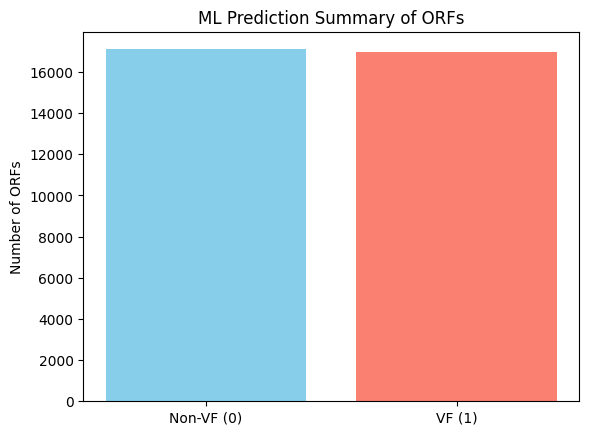

In [ ]:
# Assuming df_orf_preds already has 'ml_pred'
import matplotlib.pyplot as plt

# Count number of ORFs predicted as VF (1) and non-VF (0)
counts = df_orf_preds['ml_pred'].value_counts()
print("Predicted ORF counts:")
print(counts)

# Percentage
percentages = df_orf_preds['ml_pred'].value_counts(normalize=True) * 100
print("\nPredicted ORF percentages:")
print(percentages.round(2))

#  simple bar plot
plt.bar(counts.index.astype(str), counts.values, color=['skyblue', 'salmon'])
plt.xticks([0,1], ['Non-VF (0)', 'VF (1)'])
plt.ylabel("Number of ORFs")
plt.title("ML Prediction Summary of ORFs")
plt.show()


In [ ]:
!apt-get install ncbi-blast+ -y
!mkdir -p vfdb
!mkdir -p blast_results


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  ncbi-data
The following NEW packages will be installed:
  ncbi-blast+ ncbi-data
0 upgraded, 2 newly installed, 0 to remove and 55 not upgraded.
Need to get 15.8 MB of archives.
After this operation, 71.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 ncbi-data all 6.1.20170106+dfsg1-9 [3,519 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 ncbi-blast+ amd64 2.12.0+ds-3build1 [12.3 MB]
Fetched 15.8 MB in 3s (6,201 kB/s)
Selecting previously unselected package ncbi-data.
(Reading database ... 117594 files and directories currently installed.)
Preparing to unpack .../ncbi-data_6.1.20170106+dfsg1-9_all.deb ...
Unpacking ncbi-data (6.1.20170106+dfsg1-9) ...
Selecting previously unselected package ncbi-blast+.
Preparing to unpack .../ncbi-blast+_2.12.0+ds-3build1_amd64.deb 

In [ ]:
!apt-get install ncbi-blast+ -y
!apt-get install dos2unix -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ncbi-blast+ is already the newest version (2.12.0+ds-3build1).
0 upgraded, 0 newly installed, 0 to remove and 55 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  dos2unix
0 upgraded, 1 newly installed, 0 to remove and 55 not upgraded.
Need to get 384 kB of archives.
After this operation, 1,367 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 dos2unix amd64 7.4.2-2 [384 kB]
Fetched 384 kB in 1s (342 kB/s)
Selecting previously unselected package dos2unix.
(Reading database ... 117830 files and directories currently installed.)
Preparing to unpack .../dos2unix_7.4.2-2_amd64.deb ...
Unpacking dos2unix (7.4.2-2) ...
Setting up dos2unix (7.4.2-2) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
# Remove any existing potentially corrupted files in the target directory
!rm -f /content/vfdb/vfdb_proteins.faa.gz
!rm -f /content/vfdb/vfdb_proteins.faa

# Download the gzipped file directly into the /content/vfdb directory
!wget https://www.mgc.ac.cn/VFs/Down/VFDB_setA_pro.fas.gz -O /content/vfdb/vfdb_proteins.faa.gz

# Decompress the file using gunzip -c and redirect to the target file
# This is often more robust as it explicitly writes the decompressed content
!gunzip -c /content/vfdb/vfdb_proteins.faa.gz > /content/vfdb/vfdb_proteins.faa

# Optional: Remove the .gz file after successful decompression
!rm -f /content/vfdb/vfdb_proteins.faa.gz

# Verify file type and first few lines to ensure proper decompression
print("\nVerifying vfdb_proteins.faa:")
!file /content/vfdb/vfdb_proteins.faa
!head -n 5 /content/vfdb/vfdb_proteins.faa

--2026-02-09 21:35:43--  https://www.mgc.ac.cn/VFs/Down/VFDB_setA_pro.fas.gz
Resolving www.mgc.ac.cn (www.mgc.ac.cn)... 183.242.79.135
Connecting to www.mgc.ac.cn (www.mgc.ac.cn)|183.242.79.135|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1221455 (1.2M) [application/x-gzip]
Saving to: ‘/content/vfdb/vfdb_proteins.faa.gz’

/content/vfdb/vfdb_ 100%[===================>]   1.16M   824KB/s    in 1.4s    

2026-02-09 21:35:46 (824 KB/s) - ‘/content/vfdb/vfdb_proteins.faa.gz’ saved [1221455/1221455]


Verifying vfdb_proteins.faa:
/content/vfdb/vfdb_proteins.faa: ASCII text
>VFG037176(gb|WP_001081735) (plc1) phospholipase C [Phospholipase C (VF0470) - Exotoxin (VFC0235)] [Acinetobacter baumannii ACICU]
MNRREFLLNSTKTMFGTAALASFPLSIQKALAIDAKVESGTIQDVKHIVILTQENRSFDN
YFGTLKGVRGFGDRFTIPMTEGRKVWEQYDANKKKVLPYHLDSHLGNAQRVTGTNHSWSD
GQGAWDNGRMSDWVTHKQPQSMGYYKKQEVEYQFALANAFTICDAYHCAMHAGTNPNRKF
IWTGTNGPTGAGVASVVNEFDGIGPSTEGYEWTTYPERLQQAGVTWKVYQNMPDNFTDNP


In [ ]:
!dos2unix /content/vfdb/vfdb_proteins.faa
!makeblastdb -in /content/vfdb/vfdb_proteins.faa -dbtype prot -out /content/vfdb/vfdb_db

dos2unix: converting file /content/vfdb/vfdb_proteins.faa to Unix format...


Building a new DB, current time: 02/09/2026 21:35:47
New DB name:   /content/vfdb/vfdb_db
New DB title:  /content/vfdb/vfdb_proteins.faa
Sequence type: Protein
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 4461 sequences in 0.126316 seconds.




In [ ]:
!cp "/content/drive/MyDrive/Bioinformatics_Project/predicted_orfs.faa" /content/


In [ ]:
import subprocess

command = [
    "nohup", "blastp",
    "-query", "/content/predicted_orfs.faa",
    "-db", "/content/vfdb/vfdb_db",
    "-out", "/content/blast_results/orfs_vs_vfdb.tsv",
    "-evalue", "1e-5",
    "-outfmt", "6 qseqid sseqid pident length evalue bitscore"
]

with open("/content/blast_log.txt", "w") as outfile:
    subprocess.Popen(command, stdout=outfile, stderr=subprocess.STDOUT)

print("BLASTp process started in background. Check /content/blast_log.txt for output.")

BLASTp process started in background. Check /content/blast_log.txt for output.


In [ ]:
!blastp \
  -query /content/predicted_orfs.faa \
  -db /content/vfdb/vfdb_db \
  -out /content/blast_results/orfs_vs_vfdb.tsv \
  -evalue 1e-5 \
  -num_threads 2 \
  -outfmt "6 qseqid sseqid pident length evalue bitscore"


^C


In [ ]:
# load the BLAST results safely
import pandas as pd

blast_df = pd.read_csv(
    "/content/blast_results/orfs_vs_vfdb.tsv",
    sep="\t",
    header=None,
    names=["orf_id", "vfdb_id", "identity", "length", "evalue", "bitscore"]
)

blast_df.head()


,orf_id,vfdb_id,identity,length,evalue,bitscore
0,ORF_41,VFG002521(gb|WP_004525693),27.128,188,8.620000e-11,61.2
1,ORF_41,VFG038687(gb|WP_016350057),29.557,203,1.600000e-10,60.1
2,ORF_41,VFG007586(gb|WP_001881782),28.729,181,2.280000e-09,56.6
3,ORF_41,VFG001264(gb|NP_250144),25.243,206,3.350000e-09,55.8
4,ORF_41,VFG001895(gb|YP_002343528),25.472,212,4.300000e-09,55.5


In [ ]:
import pandas as pd

# Filter blast_df for significant hits
significant_blast_hits = blast_df[blast_df['evalue'] <= 1e-5]

# Get unique ORFs that have a significant blast hit
blast_vf_ids = significant_blast_hits['orf_id'].unique()

# Create a DataFrame indicating if an ORF has a blast VF hit
blast_vf = pd.DataFrame({'orf_id': df_orfs.index, 'blast_vf': 0})
blast_vf.loc[blast_vf['orf_id'].isin(blast_vf_ids), 'blast_vf'] = 1

print(f"Total ORFs with significant BLAST hits: {len(blast_vf_ids)}")
display(blast_vf.head())

Total ORFs with significant BLAST hits: 645


,orf_id,blast_vf
0,ORF_1,0
1,ORF_2,0
2,ORF_3,0
3,ORF_4,0
4,ORF_5,0


In [ ]:
#Compare ML vs BLAST
ml_df = pd.read_csv("/content/drive/MyDrive/Bioinformatics_Project/ORF_ML_predictions.csv")

blast_hits = set(blast_df["orf_id"])
ml_hits = set(ml_df[ml_df["ml_pred"] == 1]["id"])

both = ml_hits & blast_hits
ml_only = ml_hits - blast_hits

print("ML predicted VFs:", len(ml_hits))
print("BLAST-confirmed VFs:", len(blast_hits))
print("Overlap:", len(both))
print("ML-only (novel candidates):", len(ml_only))

ML predicted VFs: 17105
BLAST-confirmed VFs: 645
Overlap: 147
ML-only (novel candidates): 16958


In [ ]:
#SignalP-prediction
from Bio import SeqIO
import pandas as pd

def has_signal_peptide(seq):
    n_term = seq[:25]
    hydrophobic = sum(aa in "AILMFWV" for aa in n_term)
    return 1 if hydrophobic / len(n_term) > 0.4 else 0

signalp_results = []

for record in SeqIO.parse("/content/predicted_orfs.faa", "fasta"):
    signalp_results.append({
        "orf_id": record.id,
        "signalp": has_signal_peptide(str(record.seq))
    })

signalp_df = pd.DataFrame(signalp_results)
signalp_df.head()


,orf_id,signalp
0,ORF_1,0
1,ORF_2,0
2,ORF_3,1
3,ORF_4,1
4,ORF_5,1


In [ ]:
# Filter df_orf_preds to get only ORFs predicted as VFs by ML
ml_vfs_only = df_orf_preds[df_orf_preds['ml_pred'] == 1].reset_index()
ml_vfs_only = ml_vfs_only.rename(columns={'id': 'orf_id'})

# Merge with signalp_df to get SignalP predictions for these ML-predicted VFs
ml_predicted_vfs = pd.merge(ml_vfs_only, signalp_df[['orf_id', 'signalp']], on='orf_id', how='left')

print("SignalP prediction counts for ML-predicted VFs:")
display(ml_predicted_vfs['signalp'].value_counts())

SignalP prediction counts for ML-predicted VFs:


,count
signalp,
0,9701
1,7404


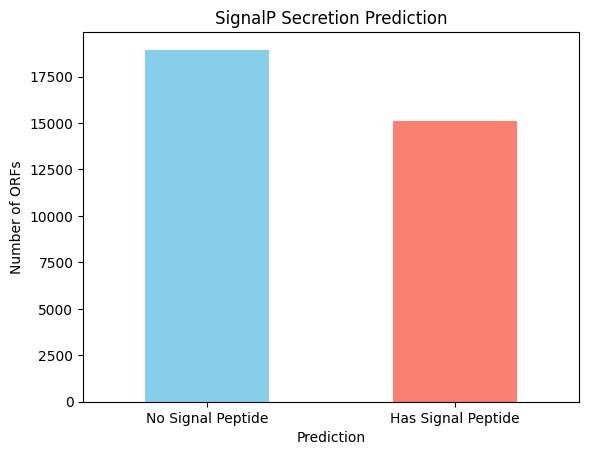

In [ ]:
import matplotlib.pyplot as plt

secreted_counts = signalp_df['signalp'].value_counts()

secreted_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("SignalP Secretion Prediction")
plt.xlabel("Prediction")
plt.ylabel("Number of ORFs")
plt.xticks([0, 1], ['No Signal Peptide', 'Has Signal Peptide'], rotation=0)
plt.show()

In [ ]:
secreted_counts = signalp_df['signalp'].value_counts()
print(secreted_counts)

signalp
0    18946
1    15128
Name: count, dtype: int64


In [ ]:
!apt-get update && apt-get install hmmer -y

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://cli.github.com/packages stable InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
hmmer is already the newest version (3.3.2+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove

In [ ]:
print("Running hmmscan...")
!hmmscan --domtblout /content/drive/MyDrive/Bioinformatics_Project/pfam_hits.tbl /content/Pfam-A.hmm /content/predicted_orfs.faa
print("hmmscan complete. Results saved to /content/drive/MyDrive/Bioinformatics_Project/pfam_hits.tbl")

Running hmmscan...

Error: File existence/permissions problem in trying to open HMM file /content/Pfam-A.hmm.
HMM file /content/Pfam-A.hmm not found (nor an .h3m binary of it); also looked in PFAMDB

hmmscan complete. Results saved to /content/drive/MyDrive/Bioinformatics_Project/pfam_hits.tbl


In [ ]:
!wget http://ftp.ebi.ac.uk/pub/databases/Pfam/releases/Pfam35.0/Pfam-A.hmm.gz
!gzip -d Pfam-A.hmm.gz


--2026-02-09 21:39:15--  http://ftp.ebi.ac.uk/pub/databases/Pfam/releases/Pfam35.0/Pfam-A.hmm.gz
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.165
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.165|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 293000230 (279M) [application/x-gzip]
Saving to: ‘Pfam-A.hmm.gz’

Pfam-A.hmm.gz       100%[===================>] 279.43M  33.2MB/s    in 9.3s    

2026-02-09 21:39:24 (30.0 MB/s) - ‘Pfam-A.hmm.gz’ saved [293000230/293000230]

^C


In [ ]:
!hmmpress Pfam-A.hmm



Error: File existence/permissions problem in trying to open HMM file Pfam-A.hmm.
HMM file Pfam-A.hmm not found (nor an .h3m binary of it)



In [ ]:
import os
import pandas as pd

# Define the path to the saved results in Google Drive
output_drive_path = "/content/drive/MyDrive/Bioinformatics_Project/pfam_hits.tbl"

# Check if the file exists
if os.path.exists(output_drive_path):
    print(f"Loading hmmscan results from: {output_drive_path}")
    # Load the data directly if it exists
    with open(output_drive_path) as f:
        hmm_hits = []
        for line in f:
            if line.startswith("#"):
                continue
            parts = line.split()
            if len(parts) >= 5:
                hmm_hits.append({
                    "orf_id": parts[2],
                    "pfam_id": parts[1],
                    "evalue": float(parts[4])
                })
    hmm_df = pd.DataFrame(hmm_hits)
    print("hmm_df loaded successfully.")
else:
    print(f"{output_drive_path} not found. Please ensure the file is in your Google Drive or run the hmmscan command to generate it.")

display(hmm_df.head())

Loading hmmscan results from: /content/drive/MyDrive/Bioinformatics_Project/pfam_hits.tbl
hmm_df loaded successfully.


,orf_id,pfam_id,evalue
0,ORF_1,PF14058.9,3.100000e-41
1,ORF_1,PF11490.11,1.900000e-02
2,ORF_1,PF06518.14,3.900000e-02
3,ORF_1,PF01274.25,8.300000e-02
4,ORF_2,PF14058.9,1.800000e-34


In [ ]:
virulence_pfams = {
    "PF01311.23",  # RTX toxin
    "PF07691.21",  # secretion system
    "PF00419.21",  # adhesin
    "PF03734.16",  # virulence regulator
}

In [ ]:
ml_df = pd.read_csv(
    "/content/drive/MyDrive/Bioinformatics_Project/ORF_ML_predictions.csv"
)
ml_df.rename(columns={'id': 'orf_id'}, inplace=True)

# Ensure all relevant dataframes are merged
# Start with ml_df
merged_all = ml_df.copy()

# Merge with blast_vf
merged_all = merged_all.merge(blast_vf, on="orf_id", how="left")
merged_all['blast_vf'] = merged_all['blast_vf'].fillna(0).astype(int)

# Merge with signalp_df
merged_all = merged_all.merge(signalp_df, on="orf_id", how="left")
merged_all['signalp'] = merged_all['signalp'].fillna(0).astype(int)

# Merge with hmm_vf (from previous steps, which already includes hmm_vf flag)
merged_all = merged_all.merge(hmm_vf, on="orf_id", how="left")
merged_all['hmm_vf'] = merged_all['hmm_vf'].fillna(0).astype(int)


print("Merged DataFrame head:")
display(merged_all.head())




Merged DataFrame head:


,orf_id,A,C,D,E,F,G,H,I,K,...,W,Y,length,hydrophobic_frac,label,ml_prob,ml_pred,blast_vf,signalp,hmm_vf
0,ORF_1,0.063830,0.028369,0.070922,0.120567,0.028369,0.028369,0.028369,0.056738,0.063830,...,0.007092,0.056738,141,0.333333,0,0.535,1,0,0,0
1,ORF_2,0.057377,0.032787,0.081967,0.114754,0.024590,0.032787,0.032787,0.057377,0.065574,...,0.008197,0.049180,122,0.319672,0,0.450,0,0,0,0
2,ORF_3,0.087379,0.029126,0.077670,0.019417,0.077670,0.029126,0.058252,0.019417,0.048544,...,0.019417,0.038835,103,0.485437,0,0.440,0,0,1,0
3,ORF_4,0.073826,0.053691,0.020134,0.026846,0.040268,0.060403,0.080537,0.060403,0.020134,...,0.000000,0.013423,149,0.489933,0,0.495,0,0,1,0
4,ORF_5,0.067055,0.001458,0.086006,0.055394,0.024781,0.061224,0.008746,0.045190,0.072886,...,0.002915,0.068513,686,0.355685,0,0.990,1,0,1,0


In [ ]:
print("DataFrame information (column types, non-null counts):")
hmm_df.info()

DataFrame information (column types, non-null counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   orf_id   44 non-null     object 
 1   pfam_id  44 non-null     object 
 2   evalue   44 non-null     float64
 3   hmm_vf   44 non-null     int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 1.5+ KB


In [ ]:
print("Descriptive statistics for hmm_df (evalue column):")
display(hmm_df.describe())

Descriptive statistics for hmm_df (evalue column):


,evalue,hmm_vf
count,4.400000e+01,44.0
mean,2.039023e-01,0.0
std,3.630897e-01,0.0
min,3.100000e-41,0.0
25%,1.650000e-02,0.0
50%,6.500000e-02,0.0
75%,1.300000e-01,0.0
max,1.600000e+00,0.0


In [ ]:
print("Running hmmscan...")
!hmmscan --domtblout /content/drive/MyDrive/Bioinformatics_Project/pfam_hits.tbl /content/Pfam-A.hmm /content/predicted_orfs.faa
print("hmmscan complete. Results saved to /content/drive/MyDrive/Bioinformatics_Project/pfam_hits.tbl")

Running hmmscan...

Error: File existence/permissions problem in trying to open HMM file /content/Pfam-A.hmm.
HMM file /content/Pfam-A.hmm not found (nor an .h3m binary of it); also looked in PFAMDB

hmmscan complete. Results saved to /content/drive/MyDrive/Bioinformatics_Project/pfam_hits.tbl


In [ ]:
hmm_df["hmm_vf"] = hmm_df["pfam_id"].isin(virulence_pfams).astype(int)

hmm_vf = hmm_df.groupby("orf_id")["hmm_vf"].max().reset_index()
hmm_vf.head()

,orf_id,hmm_vf
0,ORF_1,0
1,ORF_10,0
2,ORF_11,0
3,ORF_12,0
4,ORF_13,0


In [ ]:
print("Running hmmscan...")
!hmmscan --domtblout /content/drive/MyDrive/Bioinformatics_Project/pfam_hits.tbl /content/Pfam-A.hmm /content/predicted_orfs.faa
print("hmmscan complete. Results saved to /content/drive/MyDrive/Bioinformatics_Project/pfam_hits.tbl")

Running hmmscan...

Error: File existence/permissions problem in trying to open HMM file /content/Pfam-A.hmm.
HMM file /content/Pfam-A.hmm not found (nor an .h3m binary of it); also looked in PFAMDB

hmmscan complete. Results saved to /content/drive/MyDrive/Bioinformatics_Project/pfam_hits.tbl


In [ ]:
import os
import pandas as pd

output_drive_path = "/content/drive/MyDrive/Bioinformatics_Project/pfam_hits.tbl"

if os.path.exists(output_drive_path):
    print(f"Loading hmmscan results from: {output_drive_path}")
    with open(output_drive_path) as f:
        hmm_hits = []
        for line in f:
            if line.startswith("#"):
                continue
            parts = line.split()
            if len(parts) >= 5:
                hmm_hits.append({
                    "orf_id": parts[2],
                    "pfam_id": parts[1],
                    "evalue": float(parts[4])
                })
    hmm_df = pd.DataFrame(hmm_hits)
    print("hmm_df loaded successfully.")
else:
    print(f"{output_drive_path} not found. Please ensure the file is in your Google Drive or run the hmmscan command to generate it.")

display(hmm_df.head())

Loading hmmscan results from: /content/drive/MyDrive/Bioinformatics_Project/pfam_hits.tbl
hmm_df loaded successfully.


,orf_id,pfam_id,evalue
0,ORF_1,PF14058.9,3.100000e-41
1,ORF_1,PF11490.11,1.900000e-02
2,ORF_1,PF06518.14,3.900000e-02
3,ORF_1,PF01274.25,8.300000e-02
4,ORF_2,PF14058.9,1.800000e-34


In [ ]:
ml_df = pd.read_csv(
    "/content/drive/MyDrive/Bioinformatics_Project/ORF_ML_predictions.csv"
)
ml_df.rename(columns={'id': 'orf_id'}, inplace=True)

# Ensure all relevant dataframes are merged
# Start with ml_df
merged_all = ml_df.copy()

# Merge with blast_vf
merged_all = merged_all.merge(blast_vf, on="orf_id", how="left")
merged_all['blast_vf'] = merged_all['blast_vf'].fillna(0).astype(int)

# Merge with signalp_df
merged_all = merged_all.merge(signalp_df, on="orf_id", how="left")
merged_all['signalp'] = merged_all['signalp'].fillna(0).astype(int)

# Merge with hmm_vf (from previous steps, which already includes hmm_vf flag)
merged_all = merged_all.merge(hmm_vf, on="orf_id", how="left")
merged_all['hmm_vf'] = merged_all['hmm_vf'].fillna(0).astype(int)


print("Merged DataFrame head:")
display(merged_all.head())

Merged DataFrame head:


,orf_id,A,C,D,E,F,G,H,I,K,...,W,Y,length,hydrophobic_frac,label,ml_prob,ml_pred,blast_vf,signalp,hmm_vf
0,ORF_1,0.063830,0.028369,0.070922,0.120567,0.028369,0.028369,0.028369,0.056738,0.063830,...,0.007092,0.056738,141,0.333333,0,0.535,1,0,0,0
1,ORF_2,0.057377,0.032787,0.081967,0.114754,0.024590,0.032787,0.032787,0.057377,0.065574,...,0.008197,0.049180,122,0.319672,0,0.450,0,0,0,0
2,ORF_3,0.087379,0.029126,0.077670,0.019417,0.077670,0.029126,0.058252,0.019417,0.048544,...,0.019417,0.038835,103,0.485437,0,0.440,0,0,1,0
3,ORF_4,0.073826,0.053691,0.020134,0.026846,0.040268,0.060403,0.080537,0.060403,0.020134,...,0.000000,0.013423,149,0.489933,0,0.495,0,0,1,0
4,ORF_5,0.067055,0.001458,0.086006,0.055394,0.024781,0.061224,0.008746,0.045190,0.072886,...,0.002915,0.068513,686,0.355685,0,0.990,1,0,1,0


In [ ]:
# Function to display top ORFs per category
def top_orfs_by_class(df, category, top_n=5):
    print(f"\nTop {top_n} ORFs in category '{category}':")
    display(df[df['vf_classification'] == category].sort_values(by='vf_score', ascending=False).head(top_n))

categories = ['High-confidence VF', 'Putative VF', 'Low-confidence VF', 'Non-VF']

for cat in categories:
    top_orfs_by_class(merged_all, cat)


Top 5 ORFs in category 'High-confidence VF':


,orf_id,A,C,D,E,F,G,H,I,K,...,ml_pred,blast_vf,signalp,hmm_vf,ml_score,blast_score,hmm_score,signalp_score,vf_score,vf_classification
217,ORF_218,0.101695,0.008475,0.059322,0.067797,0.025424,0.050847,0.025424,0.084746,0.067797,...,1,1,1,0,2,4,0,1,7,High-confidence VF
623,ORF_624,0.127517,0.020134,0.033557,0.040268,0.026846,0.093960,0.013423,0.073826,0.046980,...,1,1,1,0,2,4,0,1,7,High-confidence VF
624,ORF_625,0.130137,0.020548,0.034247,0.041096,0.027397,0.095890,0.013699,0.075342,0.047945,...,1,1,1,0,2,4,0,1,7,High-confidence VF
626,ORF_627,0.138889,0.018519,0.037037,0.046296,0.018519,0.111111,0.009259,0.074074,0.055556,...,1,1,1,0,2,4,0,1,7,High-confidence VF
741,ORF_742,0.066946,0.033473,0.016736,0.027197,0.066946,0.058577,0.014644,0.135983,0.048117,...,1,1,1,0,2,4,0,1,7,High-confidence VF



Top 5 ORFs in category 'Putative VF':


,orf_id,A,C,D,E,F,G,H,I,K,...,ml_pred,blast_vf,signalp,hmm_vf,ml_score,blast_score,hmm_score,signalp_score,vf_score,vf_classification
6584,ORF_6585,0.080745,0.012422,0.074534,0.068323,0.037267,0.049689,0.015528,0.071429,0.080745,...,1,1,0,0,2,4,0,0,6,Putative VF
6583,ORF_6584,0.080247,0.012346,0.074074,0.067901,0.037037,0.049383,0.015432,0.070988,0.080247,...,1,1,0,0,2,4,0,0,6,Putative VF
216,ORF_217,0.090909,0.006993,0.048951,0.062937,0.020979,0.062937,0.027972,0.083916,0.083916,...,1,1,0,0,2,4,0,0,6,Putative VF
3197,ORF_3198,0.060773,0.005525,0.066298,0.044199,0.060773,0.066298,0.022099,0.071823,0.082873,...,1,1,0,0,2,4,0,0,6,Putative VF
1050,ORF_1051,0.090099,0.005941,0.035644,0.049505,0.050495,0.081188,0.008911,0.078218,0.053465,...,1,1,0,0,2,4,0,0,6,Putative VF



Top 5 ORFs in category 'Low-confidence VF':


,orf_id,A,C,D,E,F,G,H,I,K,...,ml_pred,blast_vf,signalp,hmm_vf,ml_score,blast_score,hmm_score,signalp_score,vf_score,vf_classification
8,ORF_9,0.058577,0.002092,0.085774,0.039749,0.027197,0.064854,0.008368,0.050209,0.066946,...,1,0,1,0,2,0,0,1,3,Low-confidence VF
16,ORF_17,0.063158,0.003509,0.089474,0.059649,0.038596,0.059649,0.001754,0.056140,0.105263,...,1,0,1,0,2,0,0,1,3,Low-confidence VF
23842,ORF_23843,0.060134,0.000000,0.089087,0.073497,0.040089,0.069042,0.046771,0.040089,0.153675,...,1,0,1,0,2,0,0,1,3,Low-confidence VF
23843,ORF_23844,0.057208,0.000000,0.091533,0.070938,0.041190,0.070938,0.048055,0.038902,0.155606,...,1,0,1,0,2,0,0,1,3,Low-confidence VF
23845,ORF_23846,0.061625,0.000000,0.095238,0.064426,0.047619,0.075630,0.050420,0.030812,0.168067,...,1,0,1,0,2,0,0,1,3,Low-confidence VF



Top 5 ORFs in category 'Non-VF':


,orf_id,A,C,D,E,F,G,H,I,K,...,ml_pred,blast_vf,signalp,hmm_vf,ml_score,blast_score,hmm_score,signalp_score,vf_score,vf_classification
34072,ORF_34073,0.047619,0.000000,0.071429,0.047619,0.087302,0.039683,0.015873,0.071429,0.071429,...,0,0,0,0,0,0,0,0,0,Non-VF
1,ORF_2,0.057377,0.032787,0.081967,0.114754,0.024590,0.032787,0.032787,0.057377,0.065574,...,0,0,0,0,0,0,0,0,0,Non-VF
15,ORF_16,0.070922,0.028369,0.056738,0.042553,0.042553,0.085106,0.042553,0.106383,0.070922,...,0,0,0,0,0,0,0,0,0,Non-VF
23,ORF_24,0.049057,0.015094,0.049057,0.094340,0.067925,0.030189,0.011321,0.041509,0.113208,...,0,0,0,0,0,0,0,0,0,Non-VF
24,ORF_25,0.046610,0.016949,0.046610,0.101695,0.072034,0.025424,0.008475,0.038136,0.114407,...,0,0,0,0,0,0,0,0,0,Non-VF


In [ ]:
import pandas as pd

def ml_score(prob):
    if prob >= 0.7:
        return 2
    elif 0.5 <= prob < 0.7:
        return 1
    else:
        return 0
# 1. Create ml_score column
merged_all['ml_score'] = merged_all['ml_pred'].apply(ml_score)

# 2. Create blast_score column
merged_all['blast_score'] = merged_all['blast_vf'] * 4

# 3. Create hmm_score column
merged_all['hmm_score'] = merged_all['hmm_vf'] * 3

# 4. Create signalp_score column
merged_all['signalp_score'] = merged_all['signalp'] * 1

# 5. Display the head of the merged_all DataFrame columns
print("Head of merged_all  columns:")
display(merged_all[['orf_id', 'ml_pred', 'ml_score', 'blast_vf', 'blast_score', 'hmm_vf', 'hmm_score', 'signalp', 'signalp_score']].head())

Head of merged_all with new score columns:


,orf_id,ml_pred,ml_score,blast_vf,blast_score,hmm_vf,hmm_score,signalp,signalp_score
0,ORF_1,1,2,0,0,0,0,0,0
1,ORF_2,0,0,0,0,0,0,0,0
2,ORF_3,0,0,0,0,0,0,1,1
3,ORF_4,0,0,0,0,0,0,1,1
4,ORF_5,1,2,0,0,0,0,1,1


In [ ]:
merged_all['vf_score'] = merged_all['ml_score'] + merged_all['blast_score'] + merged_all['hmm_score'] + merged_all['signalp_score']

print("Head of merged_all with new 'vf_score' column:")
display(merged_all[['orf_id', 'ml_score', 'blast_score', 'hmm_score', 'signalp_score', 'vf_score']].head())

Head of merged_all with new 'vf_score' column:


,orf_id,ml_score,blast_score,hmm_score,signalp_score,vf_score
0,ORF_1,2,0,0,0,2
1,ORF_2,0,0,0,0,0
2,ORF_3,0,0,0,1,1
3,ORF_4,0,0,0,1,1
4,ORF_5,2,0,0,1,3


In [ ]:
import numpy as np

# 1. Define the classification criteria based on the 'vf_score' column
def classify_vf(score):
    if score >= 7:
        return 'High-confidence VF'
    elif 4 <= score <= 6:
        return 'Putative VF'
    elif 1 <= score <= 3:
        return 'Low-confidence VF'
    else:
        return 'Non-VF'

# 2. Apply these criteria to the 'vf_score' column in the `merged_all` DataFrame
merged_all['vf_classification'] = merged_all['vf_score'].apply(classify_vf)

# 3. Display the head of the `merged_all` DataFrame with relevant columns
print("Head of merged_all with 'vf_classification':")
display(merged_all[['orf_id', 'vf_score', 'vf_classification']].head())

# 4. Print the value counts of the 'vf_classification' column
print("\nValue counts for 'vf_classification':")
print(merged_all['vf_classification'].value_counts())

Head of merged_all with 'vf_classification':


,orf_id,vf_score,vf_classification
0,ORF_1,2,Low-confidence VF
1,ORF_2,0,Non-VF
2,ORF_3,1,Low-confidence VF
3,ORF_4,1,Low-confidence VF
4,ORF_5,3,Low-confidence VF



Value counts for 'vf_classification':
vf_classification
Low-confidence VF     24460
Non-VF                 8969
Putative VF             581
High-confidence VF       64
Name: count, dtype: int64


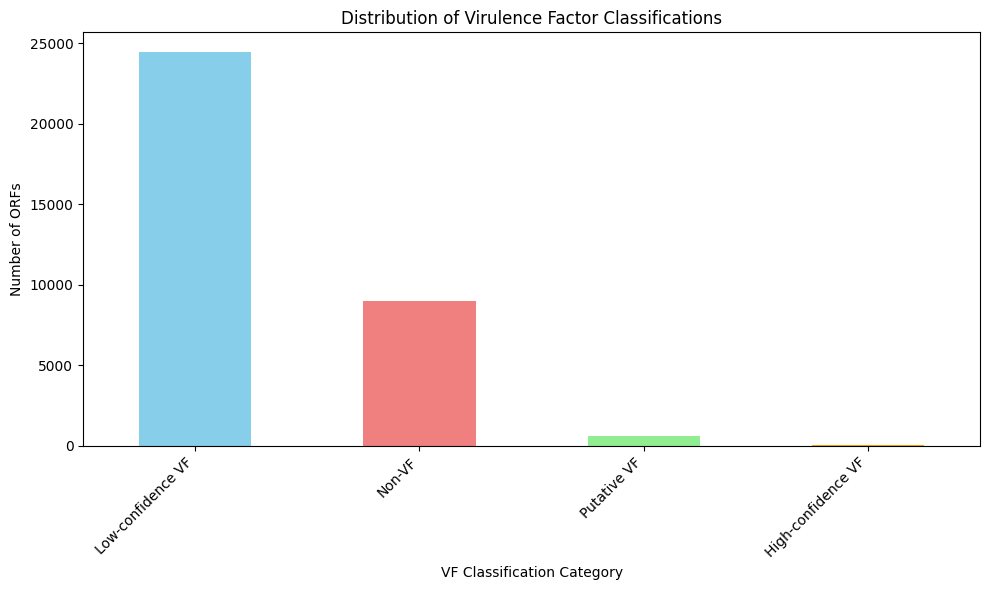

Value counts for vf_classification:
vf_classification
Low-confidence VF     24460
Non-VF                 8969
Putative VF             581
High-confidence VF       64
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt
vf_classification_counts = merged_all['vf_classification'].value_counts()
plt.figure(figsize=(10, 6))
vf_classification_counts.plot(kind='bar', color=['skyblue', 'lightcoral', 'lightgreen', 'orange'])
plt.title('Distribution of Virulence Factor Classifications')
plt.xlabel('VF Classification Category')
plt.ylabel('Number of ORFs')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print("Value counts for vf_classification:")
print(vf_classification_counts)

In [ ]:
# Display counts for each VF classification
vf_counts = merged_all['vf_classification'].value_counts()
print("Counts of ORFs by VF classification:")
display(vf_counts)

# Percentage of each class
vf_percent = (vf_counts / vf_counts.sum()) * 100
print("\nPercentage of ORFs by VF classification:")
display(vf_percent.round(2))


Counts of ORFs by VF classification:


,count
vf_classification,
Low-confidence VF,24460
Non-VF,8969
Putative VF,581
High-confidence VF,64



Percentage of ORFs by VF classification:


,count
vf_classification,
Low-confidence VF,71.78
Non-VF,26.32
Putative VF,1.71
High-confidence VF,0.19


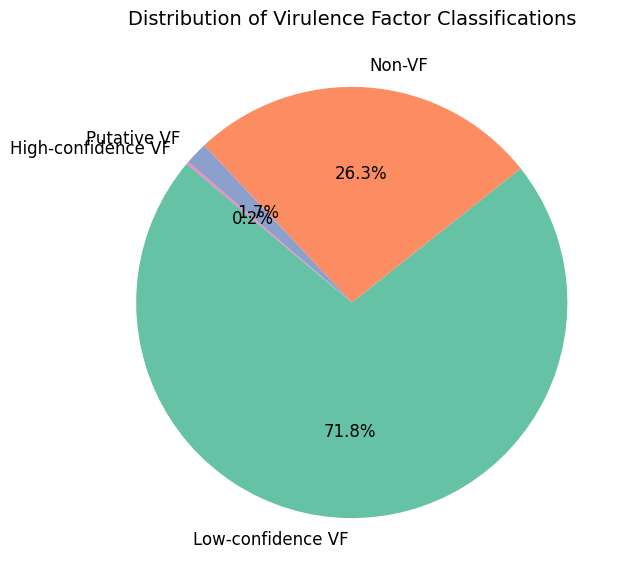

In [ ]:
vf_counts = merged_all['vf_classification'].value_counts()
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']

plt.figure(figsize=(7,7))
plt.pie(vf_counts, labels=vf_counts.index, autopct='%1.1f%%', colors=colors, startangle=140, textprops={'fontsize':12})
plt.title('Distribution of Virulence Factor Classifications', fontsize=14)
plt.show()